## Description
This version uses cell detection from TK's CNN neural network and image from Salina Long

In [68]:
import warnings
warnings.filterwarnings('ignore')
from skimage.external.tifffile import imread
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load denoised data

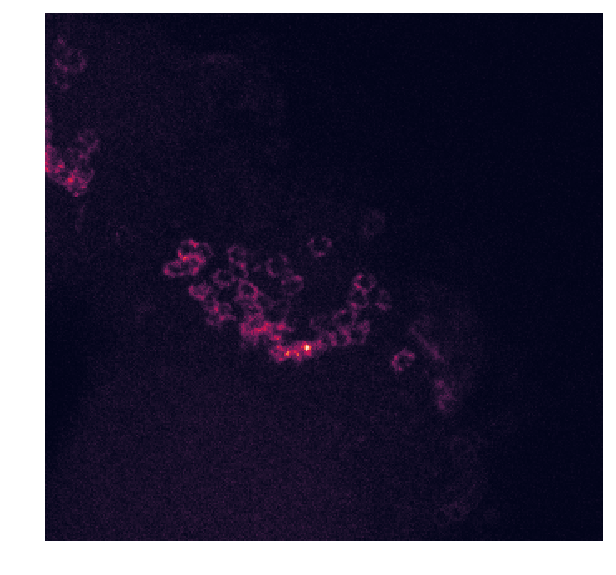

In [8]:
ave = imread('Data/Ple_count-1.tif')
plt.figure(figsize=(10, 10))
plt.imshow(ave)
plt.axis('off')
plt.show()

## 2. Identify neurons using CNN  

In [11]:
os.environ["KERAS_BACKEND"]="theano"
from roiDemixing import Imfc as im
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_fill_holes
from keras.models import load_model
from keras import backend as K
K.set_image_dim_ordering('th') # color channel first

Using Theano backend.


In [13]:
model = load_model('../roiDemixing/cell_model_32.hdf5')
from keras.utils import plot_model
plot_model(model, to_file='CellDetectionModel.png')

### 2.1 Mask the continuous area with high signals

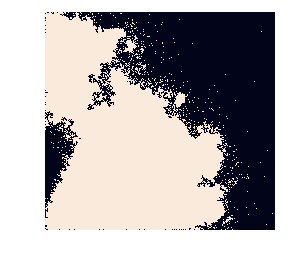

In [77]:
br_threshold1 = Y.std()*1.0
mask=binary_fill_holes(ave>br_threshold1)
plt.imshow(mask)
plt.axis('off')
plt.show()

### 2.2 Find local minima as initalization of cell centers

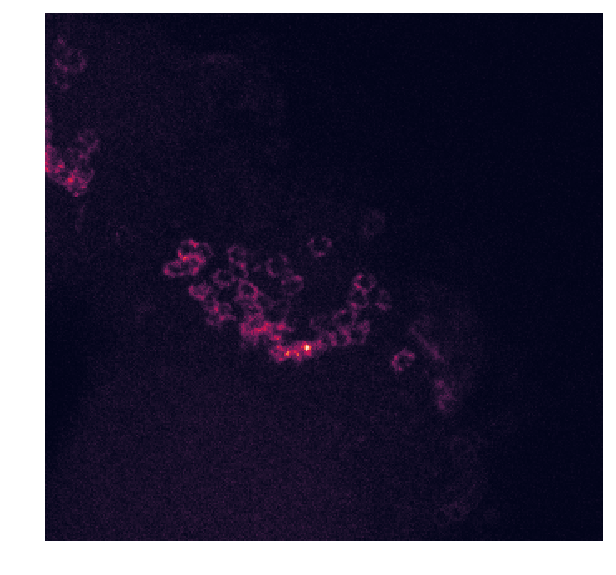

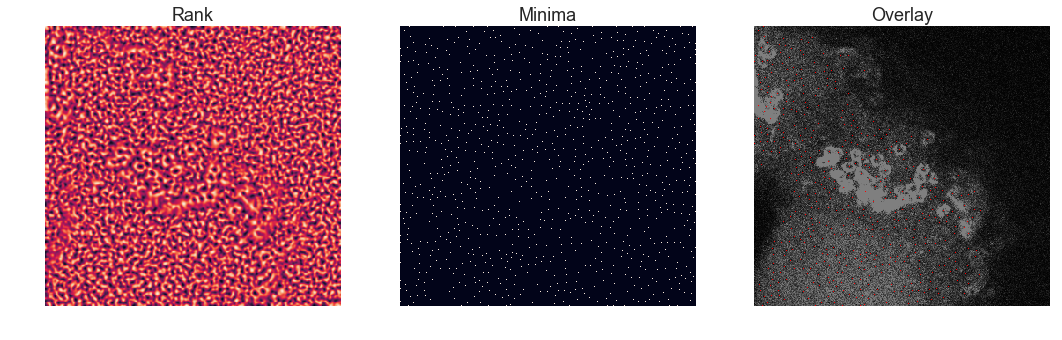

In [84]:
cell_radius=5
rank_radius=int(cell_radius*1.0)
rank_image=gaussian_filter(im.imrank_dll(gaussian_filter(ave,cell_radius*0.2),rank_radius),cell_radius*0.2)
minima_image=im.local_minima_dll(rank_image,int(cell_radius*1.0))
overlay=np.tile(im.imNormalize(ave,95)[:,:,None],(1,1,3))/2
cell_centers=np.where((minima_image>0) & mask)
cell_centers_yx=np.array([cell_centers[0],cell_centers[1]]).T
# mark the cell center in red
overlay[cell_centers[0],cell_centers[1],0]=1
overlay[cell_centers[0],cell_centers[1],1]=0
overlay[cell_centers[0],cell_centers[1],2]=0

plt.figure(figsize=(10, 10))
plt.imshow(ave)
plt.axis('off')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(18, 8))
ax[0].imshow(rank_image)
ax[0].set_axis_off()
ax[0].set_title('Rank')
ax[1].imshow(minima_image)
ax[1].set_axis_off()
ax[1].set_title('Minima')
ax[2].imshow(overlay)
ax[2].set_axis_off()
ax[2].set_title('Overlay')
plt.show()

### 2.3 Network correction for the cells

In [85]:
from skimage.transform import resize

In [86]:
image_radius= 7
image_input = 14 # fixed to 29 network
v1=ave.mean()
v2=ave.std()
ave_pad=(np.random.randn(ave.shape[0]+image_radius*2,ave.shape[1]+image_radius*2)*np.sqrt(v2))+v1
ave_pad[image_radius:-image_radius,image_radius:-image_radius]=ave
rank_pad=np.zeros((ave.shape[0]+image_radius*2,ave.shape[1]+image_radius*2))
rank_pad[image_radius:-image_radius,image_radius:-image_radius]=rank_image

# cell_r=cell_centers[0][np.where(cell_centers[0]>cell_radius*2)] # this line is unnecessary????
cell_r=cell_centers[0]
cell_c=cell_centers[1]

imlist=np.zeros((len(cell_r),1,image_input*2+1,image_input*2+1))
classlist=np.zeros((len(cell_r),))
for i in range(len(cell_r)):
    crop_img =im.imNormalize(ave_pad[cell_r[i]:(cell_r[i]+image_radius*2+1), \
          cell_c[i]:(cell_c[i]+image_radius*2+1)],50)
    imlist[i,0,:,:] = resize(crop_img, (image_input*2+1, image_input*2+1))[None,None,:,:]

scores=model.predict(imlist)
label=(scores[:,0]>0.5).astype('int')
label[np.where(label==0)]=2

inds1=np.where(label==1)[0]
inds2=np.where(label==2)[0]

disk=im.makeDisk(2)
disk_r=np.where(disk>0)[0]-2
disk_c=np.where(disk>0)[1]-2
cell_image=np.tile(im.imNormalize(ave,90)[:,:,None],(1, 1, 3))
cell_image_pad=np.zeros((cell_image.shape[0]+image_radius*2,cell_image.shape[1]+image_radius*2,3))
cell_image_pad[image_radius:-image_radius,image_radius:-image_radius,:]=cell_image
cell_image_pad2=cell_image_pad.copy()
for i in range(len(cell_r)):
    if label[i]==1:
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,0]=1
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,1]=0
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,2]=0
    if label[i]==2:
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,0]=0
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,1]=1
        cell_image_pad[cell_r[i]+disk_r+image_radius,cell_c[i]+disk_c+image_radius,2]=1

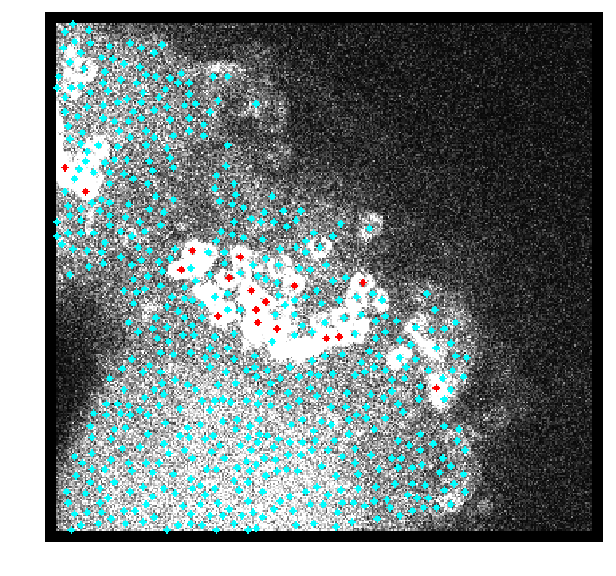

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(cell_image_pad)
plt.axis('off')
plt.show()

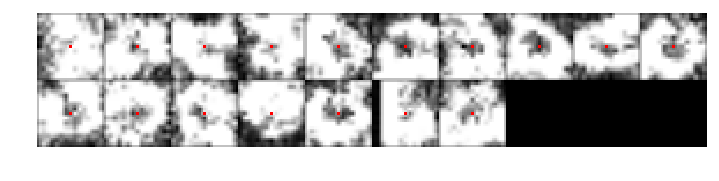

In [88]:
im.cell_images(imlist,inds1)

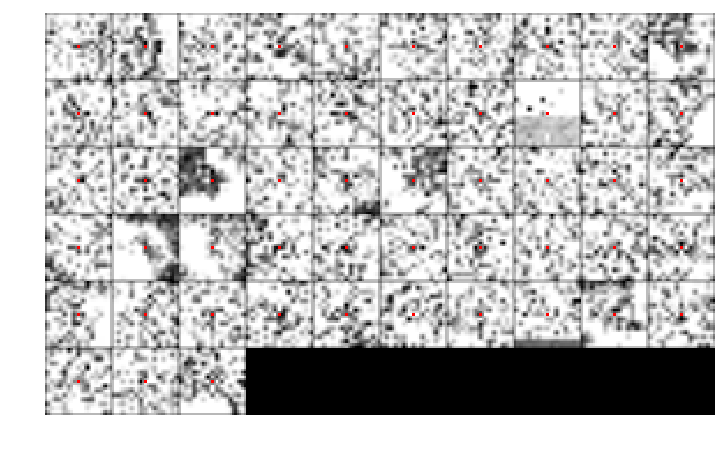

In [89]:
im.cell_images(imlist,inds2)

### 2.3 Manual proof of cell ROIs -- skip....

In [11]:
ROI_inds=im.draw_periphery(ave,cell_r,cell_c,cell_radius*2)
ROI_inds = [ROI_inds[_] for _ in inds1]